Notebook used to train models

In [85]:
#allow file access
from google.colab import files

from tensorflow.keras.models import load_model

import pickle

#import shap  
#import shap
#shap.initjs()

import pandas as pd
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior() #this was required for SHAP values
#possibly worth using the below 
#tf.compat.v1.enable_eager_executionconfig=None, device_policy=None, execution_mode=None)
from tensorflow import keras


#borrowed form 5c16
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from keras.models import model_from_json

from tensorflow.keras.callbacks import CSVLogger

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

#r2 score
#from keras import backend as K
import tensorflow.keras.backend as K
from sklearn.metrics import r2_score

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

#model optimisation api
#import tensorflow_model_optimization as tfmot

import tempfile
import os
import zipfile

%load_ext tensorboard

from tabulate import tabulate

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [86]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.metrics = []
        self.val_metrics = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('r_squared'))
        self.val_acc.append(logs.get('val_r_squared'))
        ###
        self.metrics.append(logs.get('mean_absolute_percentage_error'))         #mean_squared_error
        self.val_metrics.append(logs.get('val_mean_absolute_percentage_error')) #val_mean_squared_error
        
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(60, 20))
        plt.plot([3, 1])

        #plot 1 mean absolute percentage error
        plt.subplot(131) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('Mse')
        plt.xlabel('epoch')
        plt.title('MSE Value')
        plt.legend()

        #plot 2 r squared value
        plt.subplot(133)         
        plt.plot(self.x, self.acc, label="training r-squared")
        plt.plot(self.x, self.val_acc, label="validation r-squared")
        plt.legend()
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('R-squared')
        plt.xlabel('epoch')
        plt.title('R-Squared Value')

        #plot 3 mean squared error
        plt.subplot(132)         
        plt.plot(self.x, self.metrics, label="training mse")
        plt.plot(self.x, self.val_metrics, label="validation mse")
        plt.legend()
        plt.ylabel('Mean absolute percentage Error')
        plt.xlabel('epoch')
        plt.title('Mean absolute percentage Error')
        
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        

#creating a r^2 metric for the model evaluation
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

    

In [87]:
#create a list of channel names 
ch_names = np.arange(44).tolist()
freqs = np.arange(191.6, 195.9, 0.1).tolist()
for x in range(len(ch_names)):
  ch_names[x] = "Ch %.0f (%.1f)" % (ch_names[x], freqs[x])

In [88]:
#generate the train and testing datasets
#retreiving both datasets from GitHub
git_xval = 'https://raw.githubusercontent.com/p-owens/MAI/main/x_val.csv'
git_yval = 'https://raw.githubusercontent.com/p-owens/MAI/main/y_val.csv'
df_x = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names)

df_y = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names)

#dropping the frequences row for each training sample
df_x = df_x.iloc[1::2]
#print(df_x)

In [89]:
#select a channel to operate on
ch = 39

In [90]:
#drop all rows where df_x has a value != 0
df_chx = df_x[df_x[ch_names[ch]] !=0]
df_chy = df_y[df_y[ch_names[ch]] !=0]
df_chy = df_chy[ch_names[ch]]

#convert to numpy arrays
x_values = df_chx.to_numpy()
y_values = df_chy.to_numpy()


val_split = .2

#generate the test/validation split
#x_rem, x_test, y_rem, y_test = skl.model_selection.train_test_split(x_values, y_values, test_size=.2, random_state=0)
x_train, x_val, y_train, y_val = skl.model_selection.train_test_split(x_values, y_values, test_size = val_split, random_state = 0)#renaimed x_rem and y_rem to x_values and y_values


In [91]:
#create the models
inputs = keras.layers.Input(shape=(44,))


x = Dense(360, activation='relu')(inputs)
x = Dropout(0.45)(x) # Drop out
x = Dense(180, activation='linear')(x)
x = Dropout(0.45)(x) # Drop out
x = Dense(180, activation='relu')(x)
x = Dropout(0.45)(x) # Drop out 
x = Dense(90, activation='linear')(x)
x = Dropout(0.4)(x) # Drop out
x = Dense(45, activation='relu')(x)
x = Dropout(0.2)(x) # Drop out 
predictions = Dense(1, activation='relu')(x)

l_rate = 1 * 1e-4

# we create the model 
model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = tf.keras.optimizers.Nadam(learning_rate=l_rate)

# setup the optimisation strategy
model.compile(optimizer=opt,
              loss='mean_squared_error',      #formerly mean_absolute_percentage_error
              metrics=[r_squared, tf.keras.metrics.MeanAbsolutePercentageError()]) #tf.keras.metrics.MeanAbsolutePercentageError()


model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_30 (Dense)             (None, 360)               16200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 360)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 180)               64980     
_________________________________________________________________
dropout_26 (Dropout)         (None, 180)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 180)               32580     
_________________________________________________________________
dropout_27 (Dropout)         (None, 180)               0   

In [ ]:
#create a directroy to save the model checkpoints
#only need to run once
#path = 'model_checkpoints/'
#os.mkdir(path)

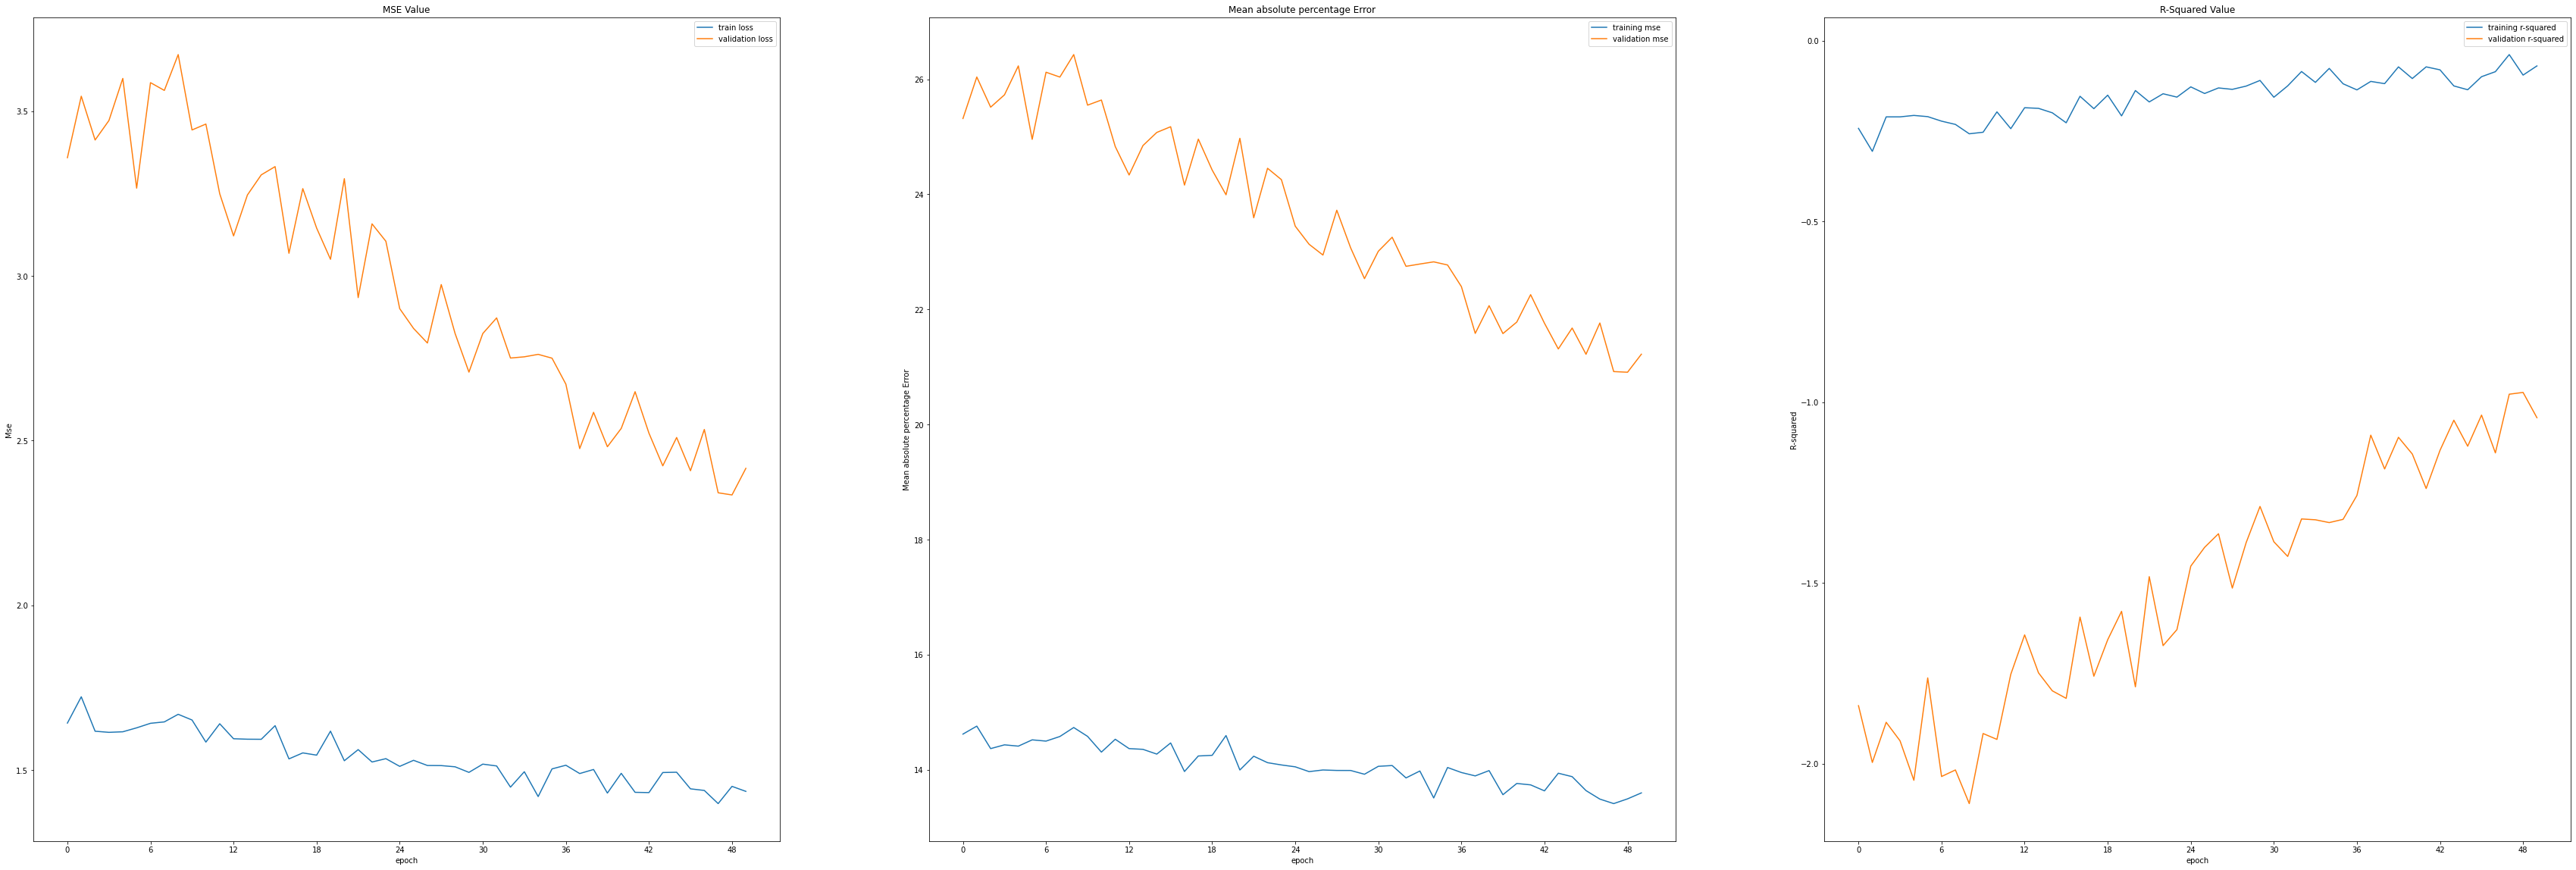


Epoch 00050: val_loss did not improve from 2.33514


In [ ]:
#callback for plotting the model metrics
#path = "checkpoint4/"
file_name = "training_2/ch_{0}.ckpt".format(ch)
log_file = "model_ch_{0}.csv".format(ch)
csv_log = CSVLogger(log_file)

pltCallBack = PlotLossAccuracy()
#callback for saving the model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= file_name, #path + file_name + "ep_{epoch:02d}_mse_{val_loss:.2f}_pct_err_{val_mean_absolute_percentage_error:.2f}.ckpt", #
                                                  monitor='val_loss',
                                                  verbose=1,
                                                  save_freq="epoch",
                                                  save_weights_only=False,
                                                  save_best_only=True,
                                                  mode='min')

batchSize = 400

# and train
model.fit(x_train, y_train,
                    batch_size=batchSize, epochs=50,   #500 ephocs gives ~ 5% error
                    validation_data=(x_val, y_val), 
                    callbacks=[pltCallBack, checkpoint_callback, csv_log])

In [ ]:
pd.read_csv(log_file, index_col='epoch')

In [ ]:
#model testing
#Using a dataset with 1 ch constantly on for the test set
#retreiving both datasets from GitHub



git_xval = ('https://raw.githubusercontent.com/p-owens/MAI/main/data%20gen/ch{0}/x_val.csv'.format(40))
git_yval = ('https://raw.githubusercontent.com/p-owens/MAI/main/data%20gen/ch{0}/y_val.csv'.format(40)) #need to replace number with ch varble
dfx = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names                                   
                 )
dfy = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names
                 )

#dropping the frequences row for each training sample
dfx = dfx.iloc[1::2]

#drop all rows where df_x has a value != 0
dfx = dfx[dfx[ch_names[ch]] !=0]
dfy = dfy[dfy[ch_names[ch]] !=0]
dfy = dfy[ch_names[ch]]

x_test = dfx.to_numpy()
y_test = dfy.to_numpy()

In [ ]:
#evaluate the model on the test set
results = model.evaluate(x_test,y_test)#, verbose=1)
print("{name1}\t\t: {mse:<.4f}\t(lower is better)\n{name2}\t: {percent_err:<.3%}\t(lower is better)".format(name1 = model.metrics_names[0],
                                                                                                    name2 = model.metrics_names[1],
                                                                                                    mse = results[0],
                                                                                                    percent_err = results[1]/100))

16/16 [==============================] - 0s 2ms/step - loss: 3.1737 - r_squared: -0.7481 - mean_absolute_percentage_error: 20.9303
loss		: 3.1737	(lower is better)
r_squared	: -0.748%	(lower is better)


In [ ]:
model= tf.keras.models.load_model("my_model", custom_objects={'r_squared': r_squared})

In [ ]:
model.save('my_model', include_optimizer=True)

INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
reconstructed_model2 = tf.keras.models.load_model("training_2/ch_39.ckpt", custom_objects={'r_squared': r_squared})
reconstructed_model2.compile(optimizer=opt,
              loss='mean_squared_error',      #formerly mean_absolute_percentage_error
              metrics=[r_squared, tf.keras.metrics.MeanAbsolutePercentageError()])
reconstructed_model2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 360)               16200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 360)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 180)               64980     
_________________________________________________________________
dropout_21 (Dropout)         (None, 180)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 180)               32580     
_________________________________________________________________
dropout_22 (Dropout)         (None, 180)               0   

In [ ]:
results = reconstructed_model2.evaluate(x_test,y_test)#, verbose=1)
print("{name1}\t\t: {mse:<.4f}\t(lower is better)\n{name2}\t: {percent_err:<.3%}\t(lower is better)".format(name1 = model.metrics_names[0],
                                                                                                    name2 = model.metrics_names[1],
                                                                                                    mse = results[0],
                                                                                                    percent_err = results[1]/100))

16/16 [==============================] - 0s 2ms/step - loss: 3.1308 - r_squared: -0.5268 - mean_absolute_percentage_error: 20.6729
loss		: 3.0389	(lower is better)
r_squared	: -0.674%	(lower is better)
